In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mymodel import MyResNet_CIFAR
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer
import matplotlib.pyplot as plt

In [2]:
# %%
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True

"""optimizer parameters"""
optim_list = [
    "Adam",
    "Adam_decay",
    "SGD",
    "SGD_nasterov",
    "AdamW",
    "AdamW_amsgrad",
    "NAdam",
]
SCHDULER = "ExponentialLR"
"""Learning rate scheduler parameters"""
NUM_EPOCHS = 100

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = NUM_EPOCHS

In [3]:
class Single_model:
    def __init__(self, optimizer, schduler, device="cuda") -> None:
        self.file_name = f"MyResNet32_{BATCH}_{optimizer}_{SCHDULER}"
        self.optim_name = optimizer
        """define model"""
        self.model = MyResNet_CIFAR(
            num_classes=10, num_layer_factor=5
        ).to(device)

        """define loss function"""
        self.criterion = nn.CrossEntropyLoss()

        """define optimizer"""
        if optimizer == "Adam":
            self.optimizer = torch.optim.Adam(self.model.parameters())
        elif optimizer == "Adam_decay":
            self.optimizer = torch.optim.Adam(
                self.model.parameters(), weight_decay=1e-4
            )
        elif optimizer == "SGD":
            self.optimizer = torch.optim.SGD(
                self.model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
            )
        elif optimizer == "SGD_nasterov":
            self.optimizer = torch.optim.SGD(
                self.model.parameters(),
                lr=0.1,
                momentum=0.9,
                weight_decay=1e-4,
                nesterov=True,
            )
        elif optimizer == "AdamW":
            self.optimizer = torch.optim.AdamW(
                self.model.parameters(), weight_decay=1e-4
            )
        elif optimizer == "AdamW_amsgrad":
            self.optimizer = torch.optim.AdamW(
                self.model.parameters(), weight_decay=1e-4, amsgrad=True
            )
        elif optimizer == "NAdam":
            self.optimizer = torch.optim.NAdam(
                self.model.parameters(), weight_decay=1e-4
            )

        """define earlystopper"""
        self.earlystopper = EarlyStopper(
            patience=EARLYSTOPPINGPATIENCE, model=self.model, file_name=self.file_name
        )

        """define learning rate scheduler"""
        if schduler == "ExponentialLR":
            self.scheduler = ExponentialLR(self.optimizer, gamma=0.95)

        """define scaler"""
        self.scaler = torch.cuda.amp.GradScaler(enabled=True)


# %%
class Single_training(Single_model):
    def __init__(self, optimizer, schduler, device="cuda"):
        super().__init__(optimizer, schduler, device)
        self.device = device
        """loading log file"""
        if os.path.exists(self.file_name + ".pth.tar"):
            # Read checkpoint as desired, e.g.,
            checkpoint = torch.load(
                self.file_name + ".pth.tar",
                map_location=lambda storage, loc: storage.cuda(self.device),
            )
            self.model.load_state_dict(checkpoint["model"])
            self.optimizer.load_state_dict(checkpoint["optimizer"])
            self.scaler.load_state_dict(checkpoint["scaler"])
            self.scheduler.load_state_dict(checkpoint["scheduler"])
            self.earlystopper.load_state_dict(checkpoint["earlystopper"])
            self.logs = checkpoint["logs"]

            print("Suceessfully loaded the All setting and Log file.")
            print(self.file_name)
            print(f"Current epoch is {len(self.logs['train_loss'])}")
            print(f"Current learning rate: {self.optimizer.param_groups[0]['lr']}")
        else:
            # Create a dictionary to store the variables
            train_loss = []
            train_acc = []
            eval_loss = []
            valid_acc = []
            test_loss = []
            test_acc = []
            lr_log = []
            self.logs = {
                "train_loss": train_loss,
                "train_acc": train_acc,
                "valid_loss": eval_loss,
                "valid_acc": valid_acc,
                "test_loss": test_loss,
                "test_acc": test_acc,
                "lr_log": lr_log,
            }
            print("File does not exist. Created a new log.")

        self.train_loss = 0.0
        self.running_loss = 0.0
        self.running_corrects = 0
        self.running_total = 0
        self.train_acc = 0

        self.test_loss = 0.0
        self.test_corrects = 0
        self.test_total = 0
        self.test_acc = 0.0
        pass

In [4]:
each_trainings = list()
for optim in optim_list:
    each_trainings.append(
        Single_training(optimizer=optim, schduler=SCHDULER, device="cuda")
    )


Suceessfully loaded the All setting and Log file.
MyResNet32_128_Adam_ExponentialLR
Current epoch is 21
Current learning rate: 0.0003405616262881147
Suceessfully loaded the All setting and Log file.
MyResNet32_128_Adam_decay_ExponentialLR
Current epoch is 21
Current learning rate: 0.0003405616262881147
Suceessfully loaded the All setting and Log file.
MyResNet32_128_SGD_ExponentialLR
Current epoch is 21
Current learning rate: 0.03405616262881148
Suceessfully loaded the All setting and Log file.
MyResNet32_128_SGD_nasterov_ExponentialLR
Current epoch is 21
Current learning rate: 0.03405616262881148
Suceessfully loaded the All setting and Log file.
MyResNet32_128_AdamW_ExponentialLR
Current epoch is 21
Current learning rate: 0.0003405616262881147
Suceessfully loaded the All setting and Log file.
MyResNet32_128_AdamW_amsgrad_ExponentialLR
Current epoch is 21
Current learning rate: 0.0003405616262881147
Suceessfully loaded the All setting and Log file.
MyResNet32_128_NAdam_ExponentialLR
Cu

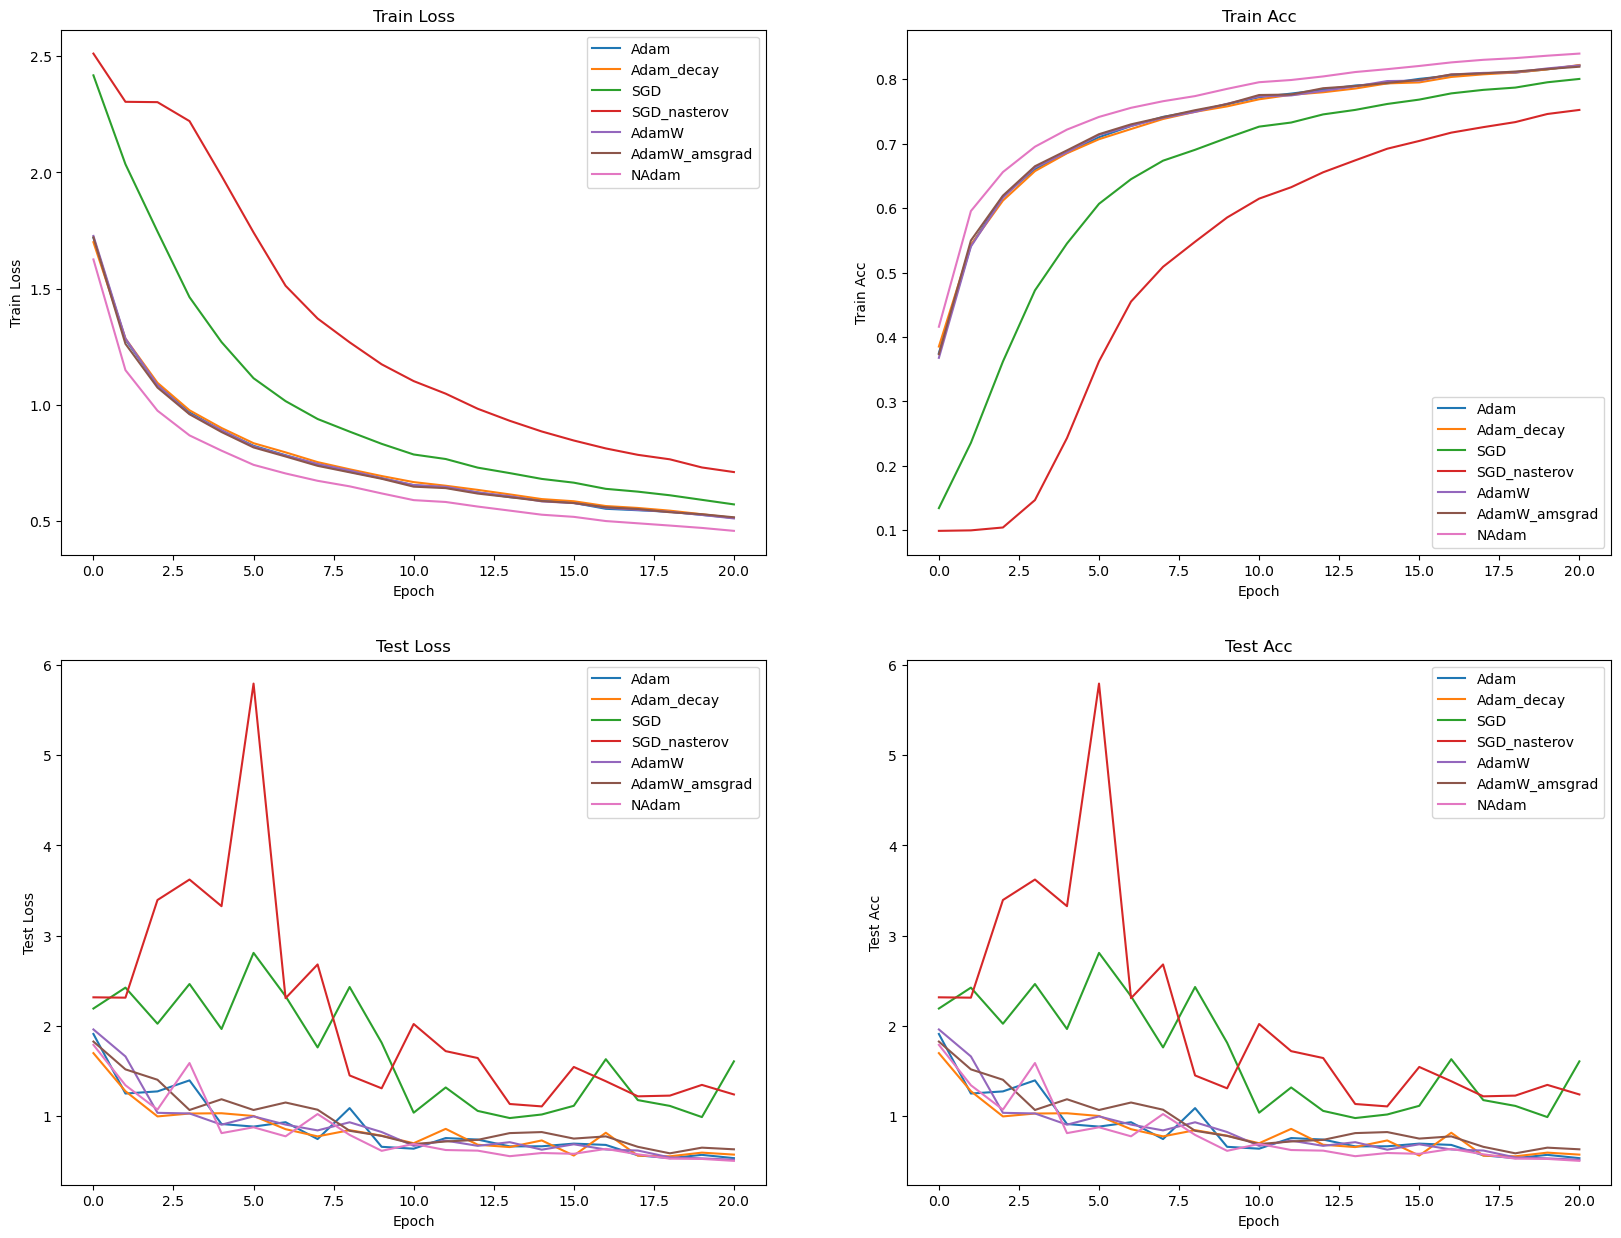

In [7]:
# Create a figure and axis
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 15))

# Plot the train_loss values from each object
for training in each_trainings:
    # ax[0][0].plot(training.logs["train_loss"], label=training.optim_name, linestyle='-', linewidth=2)
    # ax[0][1].plot(training.logs["train_acc"], label=training.optim_name, linestyle='--', linewidth=2)
    # ax[1][0].plot(training.logs["test_loss"], label=training.optim_name, linestyle=':', linewidth=2)
    # ax[1][1].plot(training.logs["test_loss"], label=training.optim_name, linestyle='-.', linewidth=2)
    ax[0][0].plot(training.logs["train_loss"], label=training.optim_name)
    ax[0][1].plot(training.logs["train_acc"], label=training.optim_name)
    ax[1][0].plot(training.logs["test_loss"], label=training.optim_name)
    ax[1][1].plot(training.logs["test_loss"], label=training.optim_name)

# Set labels and title
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Train Loss")
ax[0][0].set_title("Train Loss")
ax[0][0].legend()

ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Train Acc")
ax[0][1].set_title("Train Acc")
ax[0][1].legend()

ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Test Loss")
ax[1][0].set_title("Test Loss")
ax[1][0].legend()

ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Test Acc")
ax[1][1].set_title("Test Acc")
ax[1][1].legend()

# Add a legend


# Show the plot
plt.show()

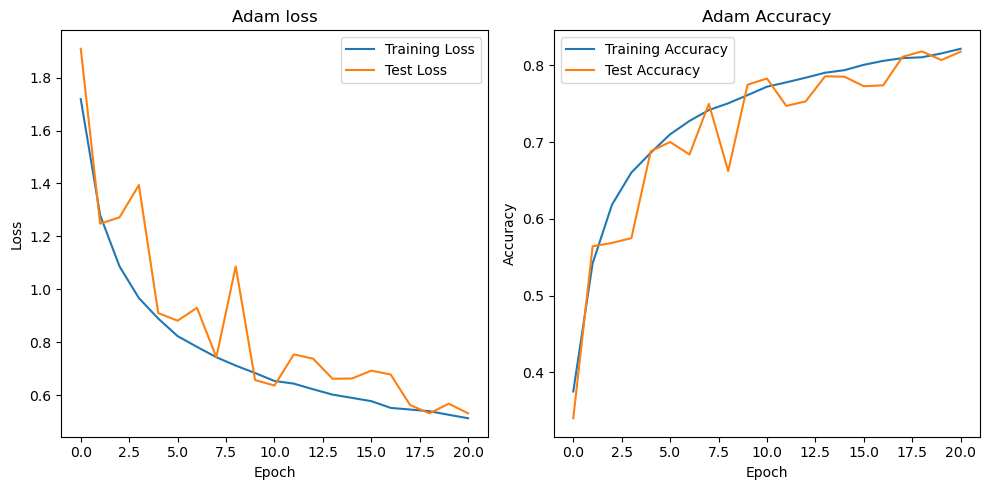

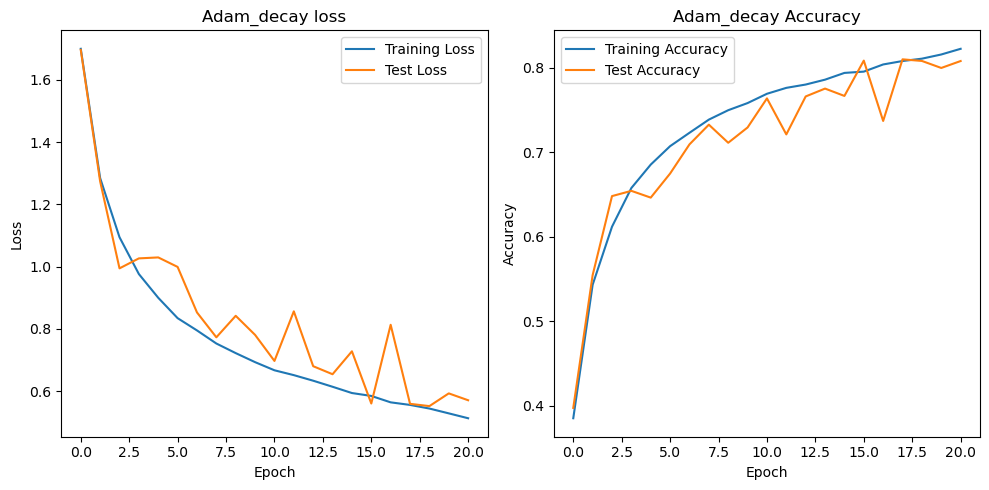

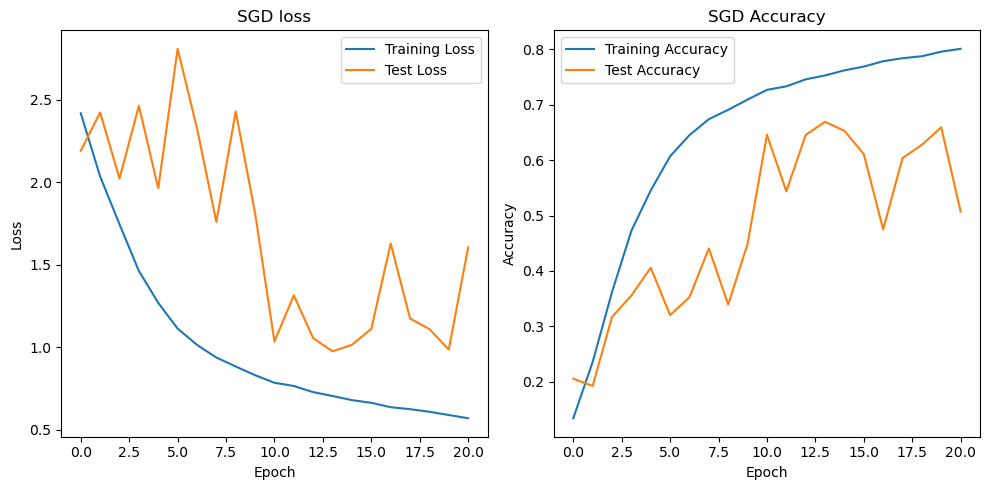

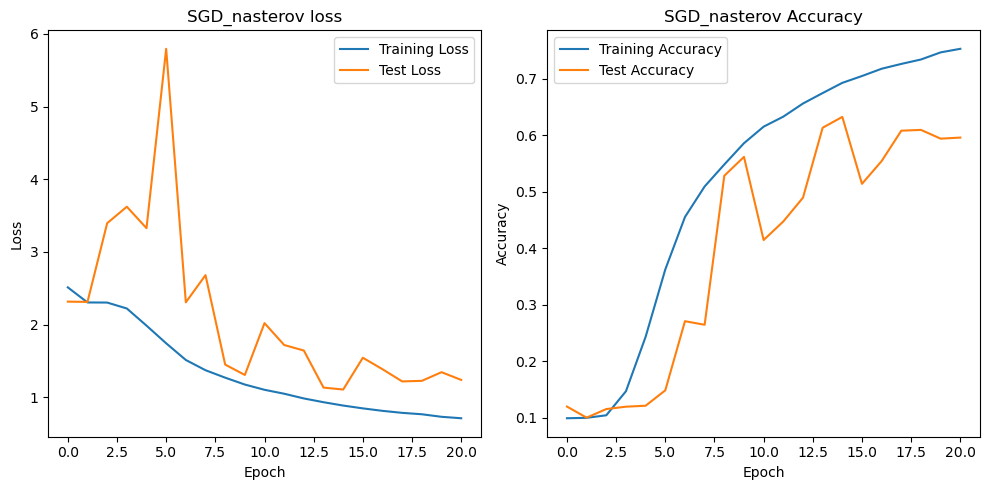

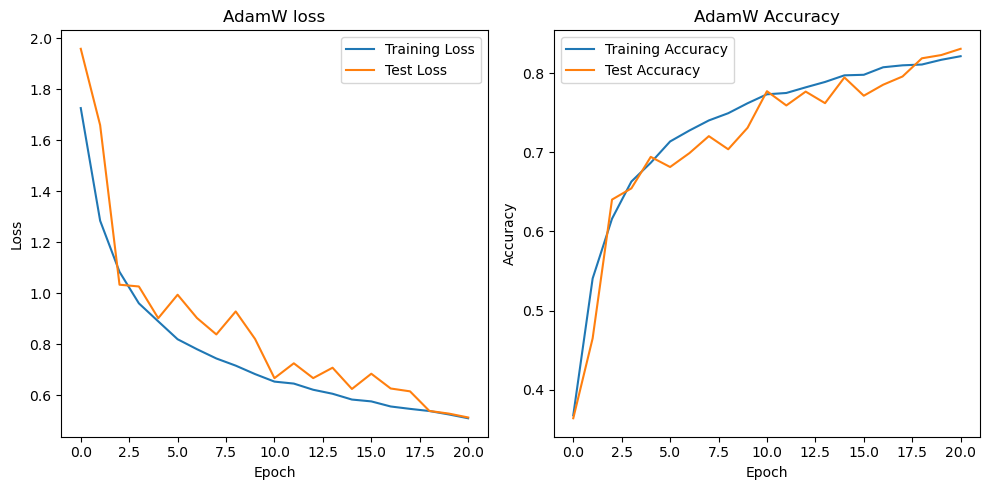

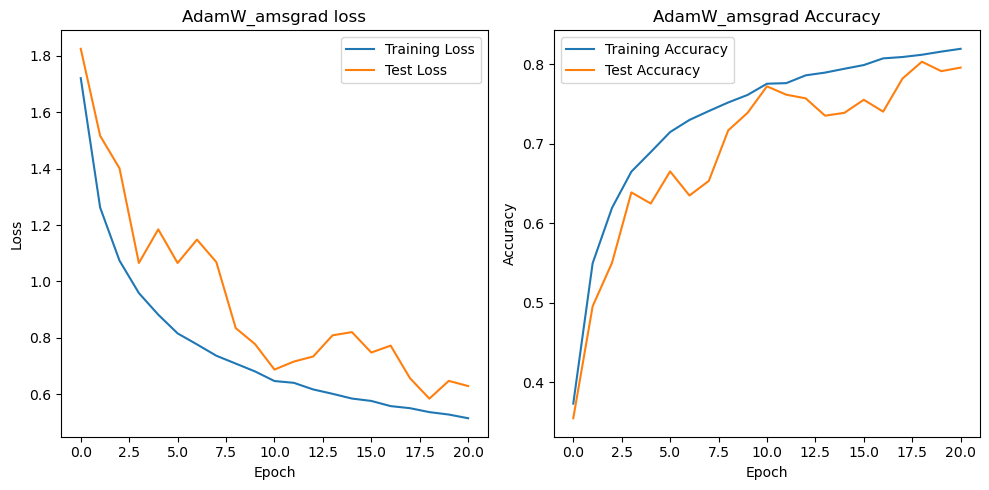

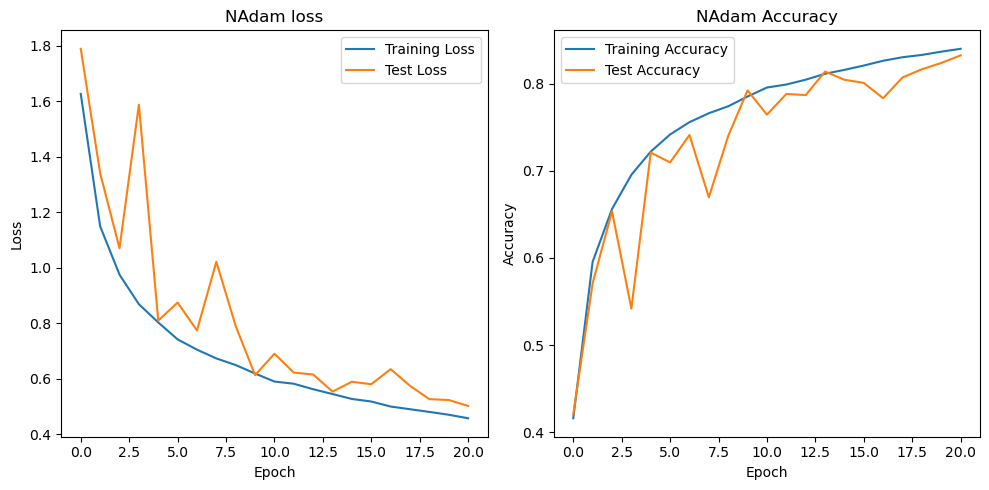

In [8]:
for training in each_trainings:
    viewer = LogViewer(training.logs)
    viewer.draw(title=training.optim_name, min_marker=False)